In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv("ReadySoilDataset_Final.csv")

df.head(10)

,Region,Year,Month,SoilTemperature-10,SoilTemperature-30,SoilTemperature-50,Rainfall,Temperature,Min Temperature,Max Temperature,Humidity,Sunshine,Wind Speed,Surface Pressure,Solar Radiation
0,0,2001,1,17.89,19.85,19.94,0.0,17.08,10.13,25.71,80.48,8.92,2.24,101281.92,207.58
1,0,2001,2,21.95,22.76,22.13,64.0,21.82,14.94,29.49,78.07,8.60,2.06,101059.03,214.45
2,0,2001,3,26.32,27.46,26.37,21.0,25.91,19.05,33.12,74.81,8.03,2.22,100912.25,253.59
3,0,2001,4,30.51,31.25,29.97,51.0,28.98,23.57,34.57,75.23,6.84,2.96,100700.03,259.83
4,0,2001,5,30.05,31.21,30.41,244.0,28.28,23.70,32.84,86.23,4.99,2.66,100247.55,187.60
5,0,2001,6,29.88,31.05,30.12,355.0,27.53,25.04,30.62,92.00,1.87,3.69,99951.43,135.68
6,0,2001,7,31.15,31.80,30.82,272.0,28.18,25.34,31.28,89.87,3.84,4.05,100016.29,162.97
7,0,2001,8,31.93,32.54,31.56,188.0,29.10,26.03,32.18,87.32,4.85,3.32,100137.40,183.63
8,0,2001,9,31.03,31.98,31.18,207.0,28.30,25.24,31.78,88.77,4.22,2.14,100522.90,169.82
9,0,2001,10,29.89,30.92,30.24,196.0,27.49,24.03,31.89,87.32,6.51,1.77,100872.53,161.77


In [10]:


features = df[['Month', 'Temperature', 'Min Temperature',
               'Max Temperature','Rainfall','Surface Pressure']]
target = df['SoilTemperature-50']


feat_scaler = StandardScaler()
X_scaled = feat_scaler.fit_transform(features)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1))


def create_sliding_window(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

WINDOW = 3
X_seq, y_seq = create_sliding_window(X_scaled, y_scaled, WINDOW)

total_samples = len(X_seq)
train_end = int(0.7 * total_samples)
val_end = int(0.85 * total_samples)

X_train, y_train = X_seq[:train_end], y_seq[:train_end]
X_val, y_val = X_seq[train_end:val_end], y_seq[train_end:val_end]
X_test, y_test = X_seq[val_end:], y_seq[val_end:]

model = Sequential([
    SimpleRNN(64, activation='tanh', return_sequences=True,
              input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    SimpleRNN(32, activation='tanh', return_sequences=True),
    Dropout(0.2),
    SimpleRNN(32, activation='tanh', return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)                          
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])


early_stop  = EarlyStopping(monitor='val_loss',
                            patience=10,
                            restore_best_weights=True)
checkpoint  = ModelCheckpoint('best_simple_rnn.h5',
                              monitor='val_loss',
                              save_best_only=True,
                              mode='min')
lr_sched    = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=5,
                                min_lr=1e-6)


history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint, lr_sched],
    verbose=1
)


loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test MAE:       {mae:.4f}")


y_pred_scaled = model.predict(X_test)
y_pred        = tgt_scaler.inverse_transform(y_pred_scaled)
y_true        = tgt_scaler.inverse_transform(y_test)

comparison = pd.DataFrame({
    'Predicted': y_pred.flatten(),
    'Actual':    y_true.flatten()
})
print(comparison.head(14))


Epoch 1/100
47/47 [==============================] - 4s 19ms/step - loss: 0.1367 - mae: 0.2909 - val_loss: 0.0286 - val_mae: 0.1296 - lr: 0.0010
Epoch 2/100
12/47 [======>.......................] - ETA: 0s - loss: 0.0906 - mae: 0.2364

C:\Users\HP Laptop 15\tfenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 0s 6ms/step - loss: 0.0721 - mae: 0.2091 - val_loss: 0.0288 - val_mae: 0.1243 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 0s 6ms/step - loss: 0.0573 - mae: 0.1880 - val_loss: 0.0300 - val_mae: 0.1383 - lr: 0.0010
Epoch 4/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0465 - mae: 0.1692 - val_loss: 0.0219 - val_mae: 0.1019 - lr: 0.0010
Epoch 5/100
47/47 [==============================] - 0s 6ms/step - loss: 0.0395 - mae: 0.1542 - val_loss: 0.0224 - val_mae: 0.1062 - lr: 0.0010
Epoch 6/100
47/47 [==============================] - 0s 6ms/step - loss: 0.0380 - mae: 0.1518 - val_loss: 0.0222 - val_mae: 0.1059 - lr: 0.0010
Epoch 7/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0322 - mae: 0.1395 - val_loss: 0.0201 - val_mae: 0.0990 - lr: 0.0010
Epoch 8/100
47/47 [==============================] - 0s 6ms/step - loss: 0.0293 - mae: 0.1322 - val_loss: 0.0205 - val_mae: 0.1010 - lr: 0.0010
Epoc

In [ ]:
WINDOW=12
Test Loss (MSE): 0.0237
Test MAE:       0.0992

WINDOW = 9
Test Loss (MSE): 0.0250
Test MAE:       0.1006

WINDOW = 6
Test Loss (MSE): 0.0288
Test MAE:       0.1125

WINDOW = 3
Test Loss (MSE): 0.0260
Test MAE:       0.1088

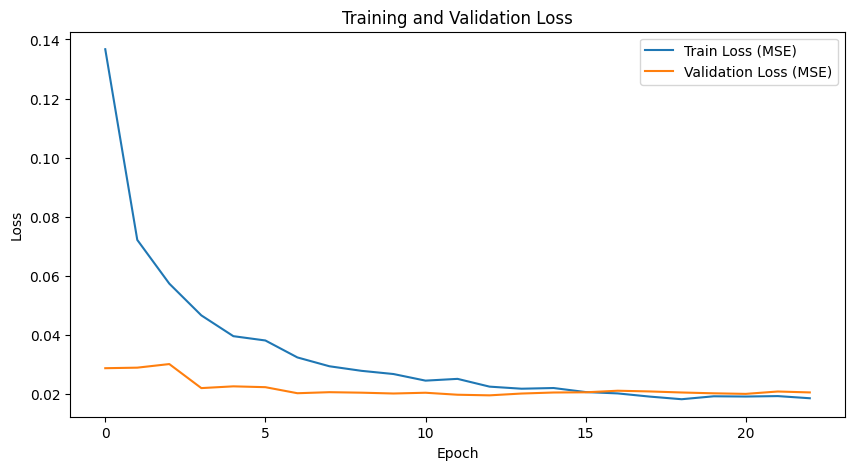

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()